# Imports and definitions

In [15]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../source")))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils.custom_classes.GarbageClassifier import GarbageClassifier
from utils.custom_classes.GarbageDataModule import GarbageDataModule
from utils import config as cfg

In [12]:
def plot_top_misclassified(df, y_true, y_pred, y_proba, dataset_path, N=10):
    """
    Plot the top N misclassified examples with the lowest confidence in the true class.
    
    df: pandas DataFrame with 'filename' and 'label' columns
    y_true: array-like of true labels (ints or strings)
    y_pred: array-like of predicted labels (ints or strings)
    y_proba: array-like of predicted probabilities (shape: n_samples x n_classes)
    dataset_path: path to dataset root folder
    N: number of misclassified samples to show
    """
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle case: y_true are integers vs strings
    if np.issubdtype(y_true.dtype, np.integer):
        true_indices = y_true
        classes = sorted(df['label'].unique())  # class names for plotting
    else:
        classes = sorted(np.unique(y_true))
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        true_indices = np.array([class_to_idx[label] for label in y_true])
    
    # Confidence in the true class
    true_confidences = y_proba[np.arange(len(y_true)), true_indices]
    
    # Find misclassified samples
    misclassified_idx = np.where(y_true != y_pred)[0]
    
    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return
    
    # Sort misclassified by confidence in true class (ascending)
    sorted_idx = misclassified_idx[np.argsort(true_confidences[misclassified_idx])]
    
    # Select top N worst
    selected_idx = sorted_idx[:N]
    
    # Plot
    plt.figure(figsize=(15, 3 * (N // 5 + 1)))
    for i, idx in enumerate(selected_idx, 1):
        row = df.iloc[idx]
        img_path = os.path.join(dataset_path, row['label'], row['filename'])

        if not os.path.exists(img_path):
            print(f"⚠️ File not found: {img_path}")
            continue
        
        try:
            print(img_path)
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Error opening {img_path}: {e}")
            continue
        
        plt.subplot(int(np.ceil(N/5)), 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"True: {row['label']}\nPred: {classes[y_pred[idx]]}\nConf True: {true_confidences[idx]:.2f}",
            fontsize=9,
            color="red"
        )
    
    plt.tight_layout()
    plt.show()

In [3]:
ROOT_PATH = os.path.join("..", "data", "raw")
DATASET_PATH = os.path.join(ROOT_PATH, "sample_dataset")
metadata_path = os.path.join(os.path.join(ROOT_PATH, "Garbage_Dataset_Classification"), "metadata.csv")
df = pd.read_csv(metadata_path)

# Loss curves

In [4]:
with open("../data/o/loss_curves/metrics.json", "r") as f:
    metrics = json.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
val_accs = metrics["val_accs"]

In [5]:
print(len(train_losses), len(val_losses))

10 10


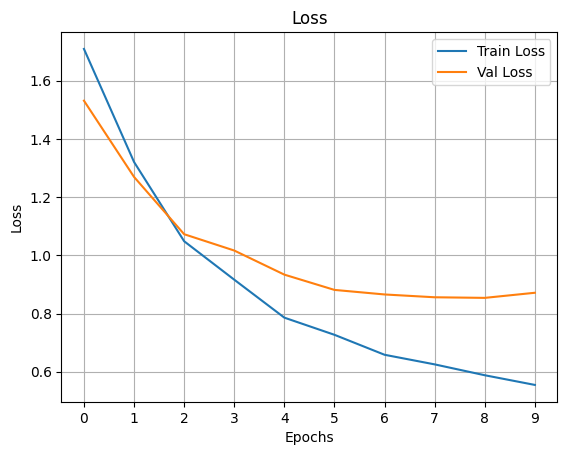

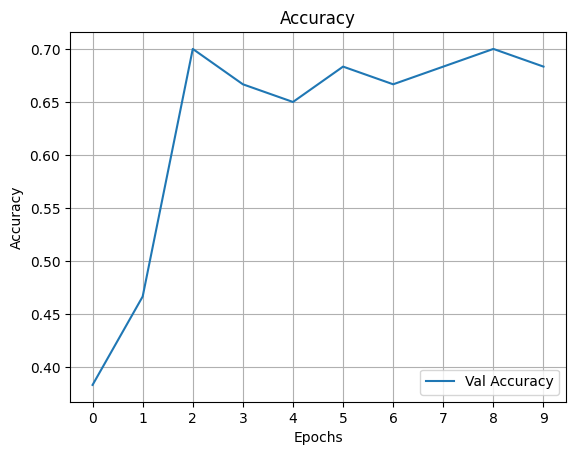

In [6]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss")
plt.xticks(range(len(train_losses)))
plt.grid(True)
plt.show()

plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy")
plt.xticks(range(len(train_losses)))
plt.grid(True)
plt.show()

# Prediction analysis

In [7]:
print(f"Loading model...")
model = GarbageClassifier.load_from_checkpoint(cfg.MODEL_PATH, num_classes = cfg.NUM_CLASSES)
print(f"Done")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

Loading model...
Done


GarbageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [8]:
data_module = GarbageDataModule(batch_size=32)
data_module.setup()

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

## Train set

In [9]:
all_preds_train = []
all_labels_train = []
all_probs_train = []

with torch.no_grad():
    for xb, yb in train_loader:
        out = model(xb)                  # logits
        preds = out.argmax(dim=1)        # classes
        probs = torch.softmax(out, dim=1)# probabilities
        all_probs_train.append(probs.cpu())
        all_preds_train.append(preds)
        all_labels_train.append(yb)

all_preds_train = torch.cat(all_preds_train)
all_labels_train = torch.cat(all_labels_train)
all_probs_train = torch.cat(all_probs_train).numpy()

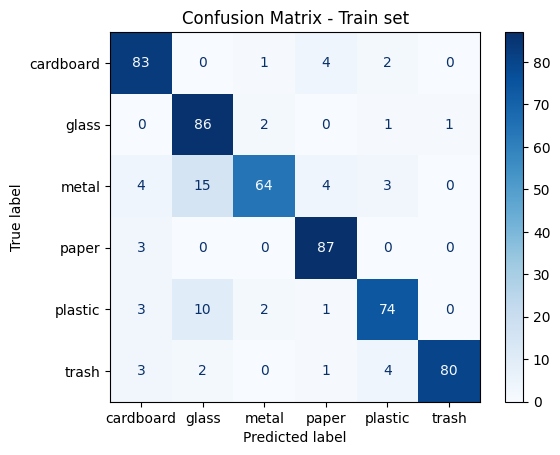

Clase 0: TP=83, FP=13, FN=7, TN=437
Clase 1: TP=86, FP=27, FN=4, TN=423
Clase 2: TP=64, FP=5, FN=26, TN=445
Clase 3: TP=87, FP=10, FN=3, TN=440
Clase 4: TP=74, FP=10, FN=16, TN=440
Clase 5: TP=80, FP=1, FN=10, TN=449


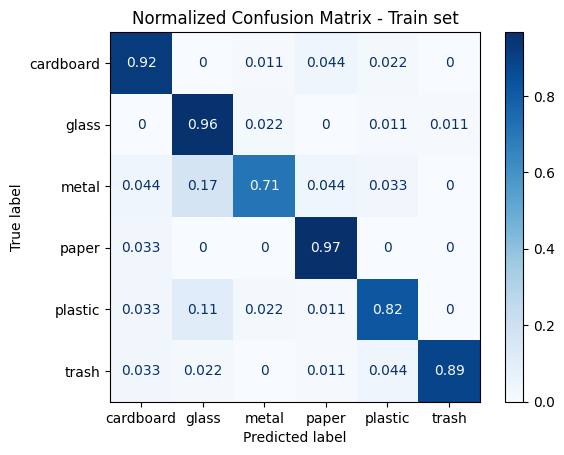

In [10]:
num_classes = data_module.num_classes

# ================================
# Confussion Matrix - Train set
# ================================
cm = confusion_matrix(all_labels_train, all_preds_train, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(cfg.CLASS_NAMES))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train set")
plt.show()

# ================================
# TP, FP, FN, TN per class
# ================================
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

for i in range(num_classes):
    print(f"Clase {i}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, TN={TN[i]}")

# ================================
# Normalized Confussion Matrix - Train set
# ================================
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=(cfg.CLASS_NAMES))
disp_norm.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix - Train set")
plt.show()

⚠️ File not found: ../data/raw/sample_dataset/cardboard/cardboard_02925.jpg
../data/raw/sample_dataset/cardboard/cardboard_02247.jpg
⚠️ File not found: ../data/raw/sample_dataset/cardboard/cardboard_02215.jpg


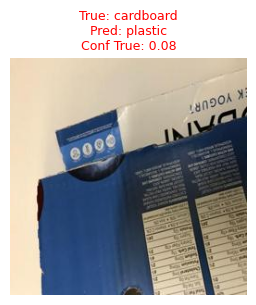

In [16]:
plot_top_misclassified(df, all_labels_train, all_preds_train, all_probs_train, DATASET_PATH, N=3)

## Test set

In [8]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb)                  # logits
        preds = out.argmax(dim=1)        # classes
        probs = torch.softmax(out, dim=1)# probabilities
        all_probs.append(probs.cpu())
        all_preds.append(preds)
        all_labels.append(yb)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_probs = torch.cat(all_probs).numpy()

In [ ]:
plot_top_misclassified(df, y_true, y_pred, y_proba, dataset_path, N=10)

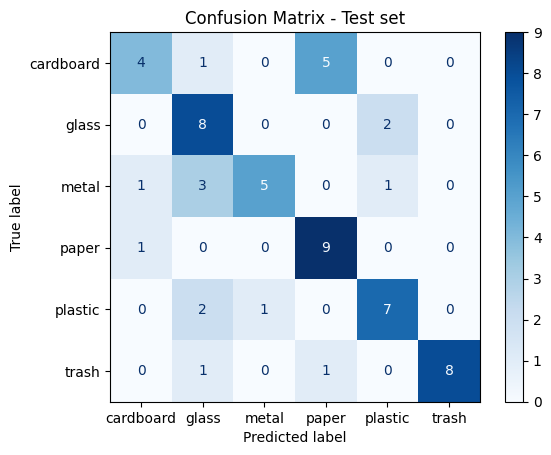

Clase 0: TP=4, FP=2, FN=6, TN=48
Clase 1: TP=8, FP=7, FN=2, TN=43
Clase 2: TP=5, FP=1, FN=5, TN=49
Clase 3: TP=9, FP=6, FN=1, TN=44
Clase 4: TP=7, FP=3, FN=3, TN=47
Clase 5: TP=8, FP=0, FN=2, TN=50


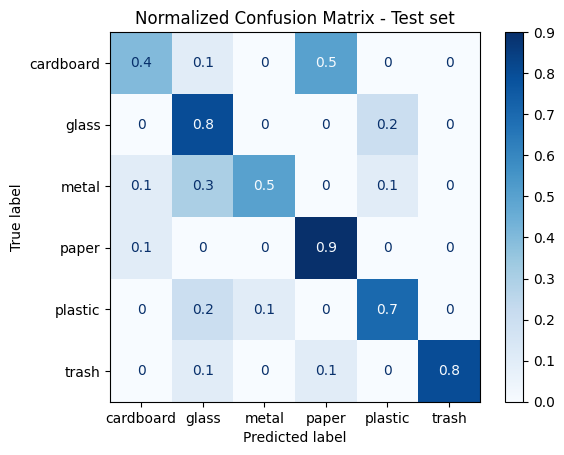

In [10]:
num_classes = data_module.num_classes

# ================================
# Confussion Matrix - Test set
# ================================
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(cfg.CLASS_NAMES))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test set")
plt.show()

# ================================
# TP, FP, FN, TN per class
# ================================
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

for i in range(num_classes):
    print(f"Clase {i}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, TN={TN[i]}")

# ================================
# Normalized Confussion Matrix
# ================================
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=(cfg.CLASS_NAMES))
disp_norm.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix - Test set")
plt.show()

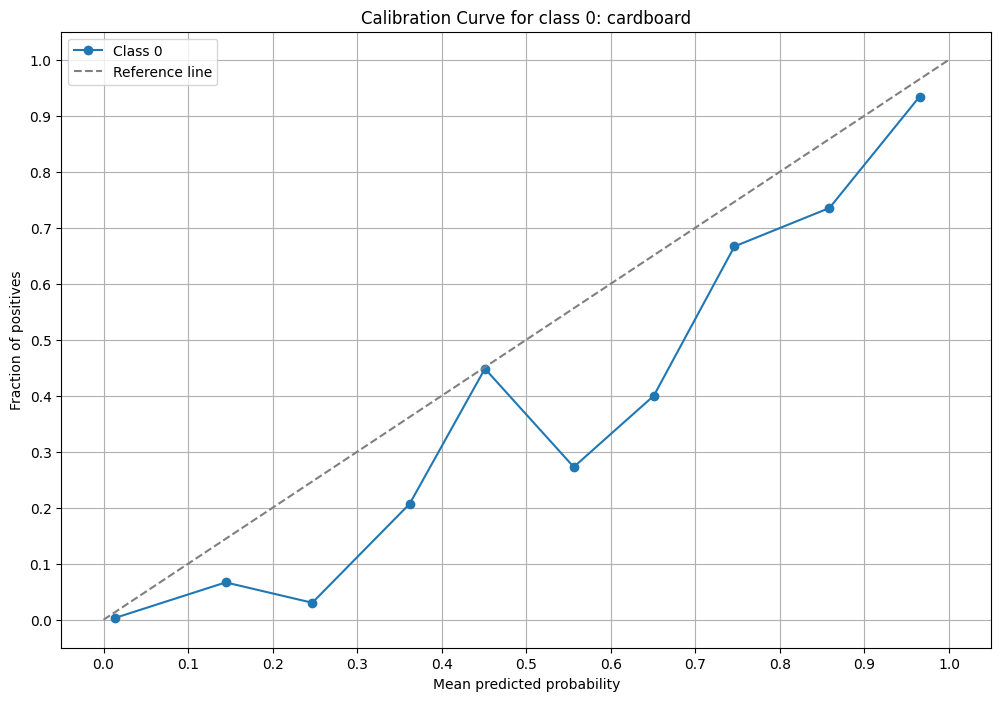

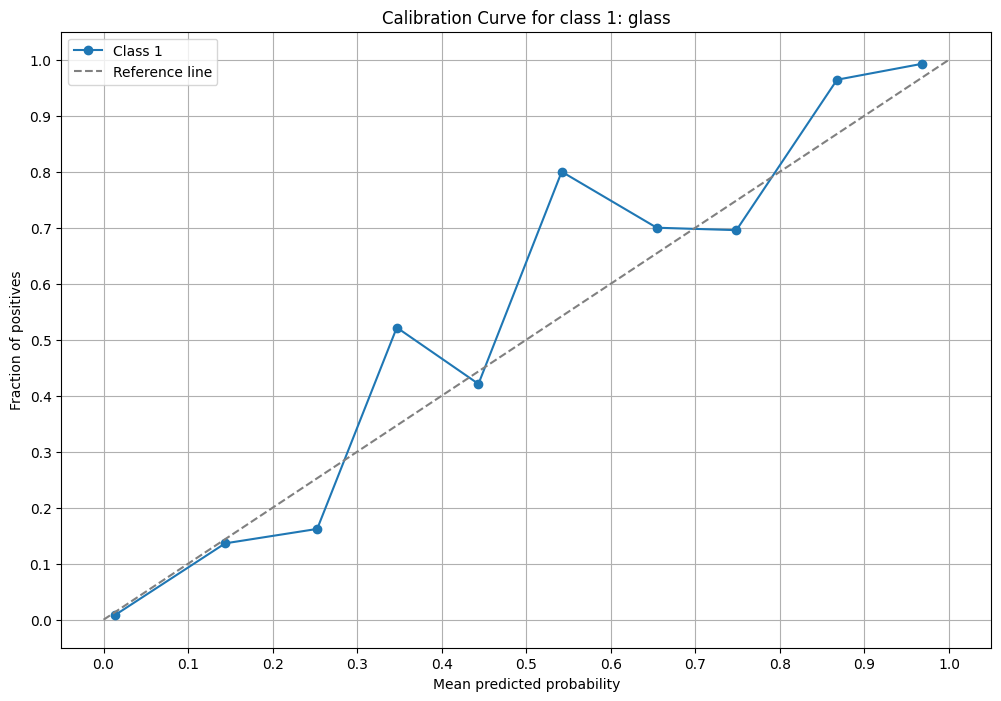

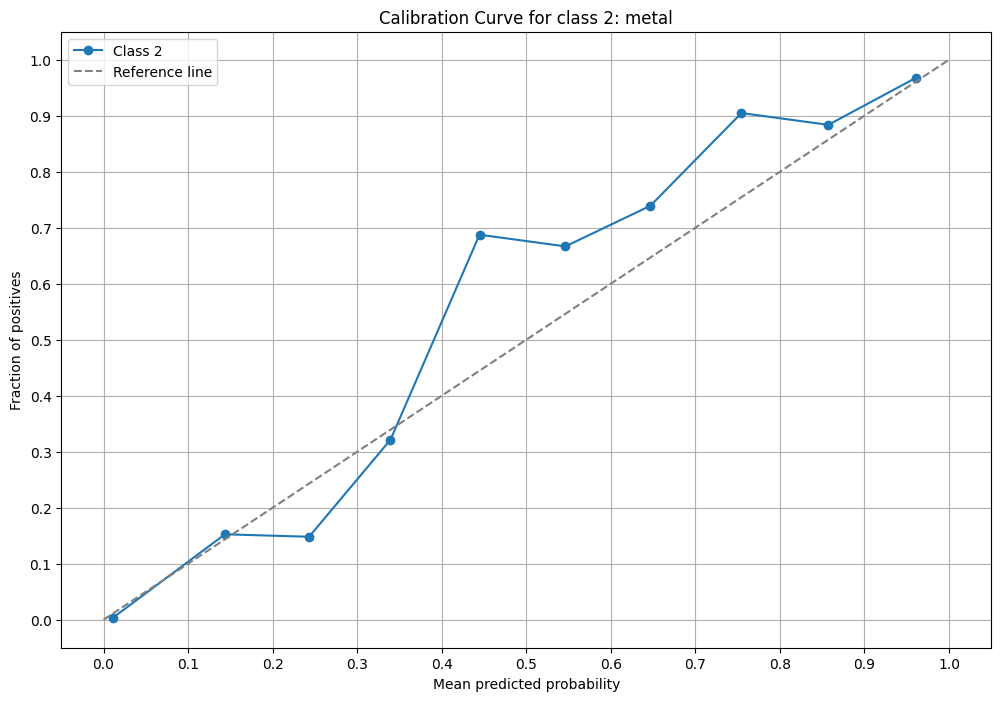

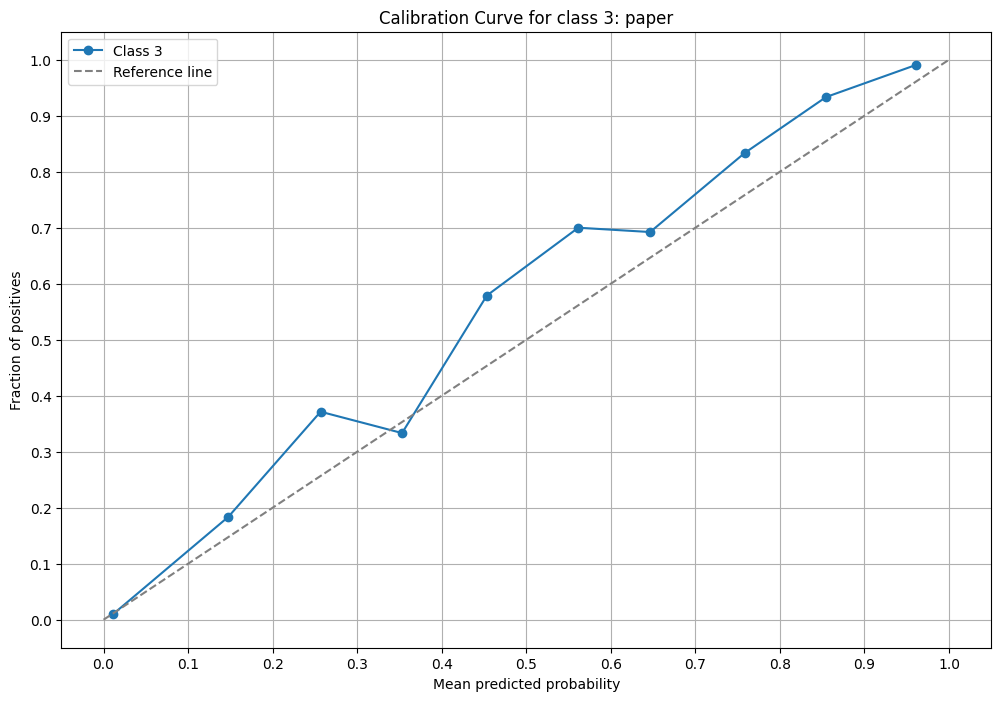

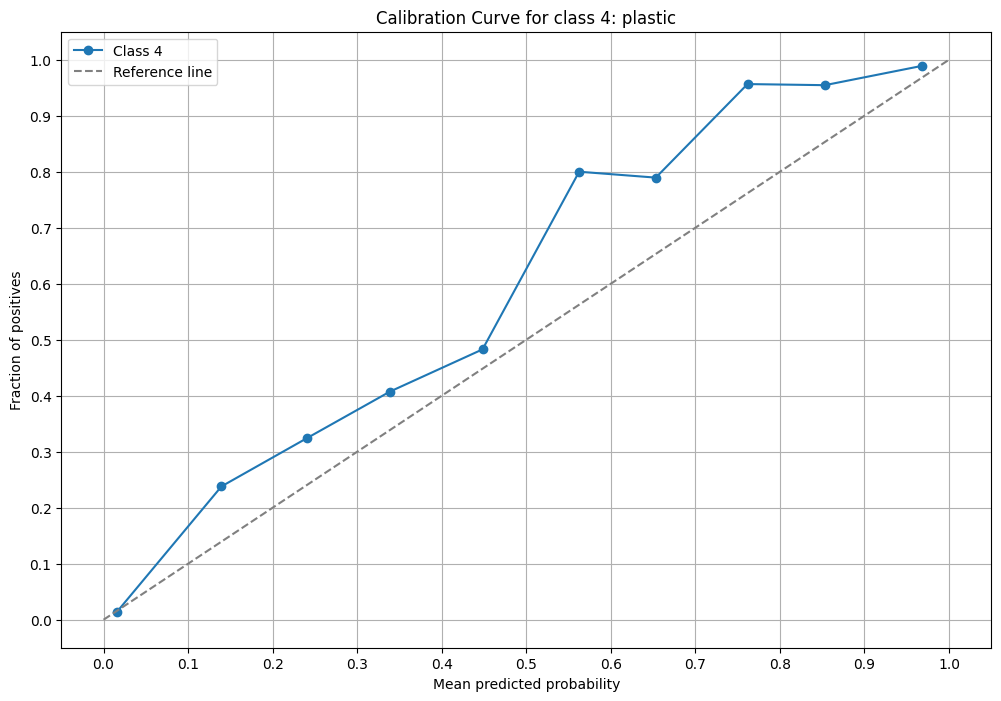

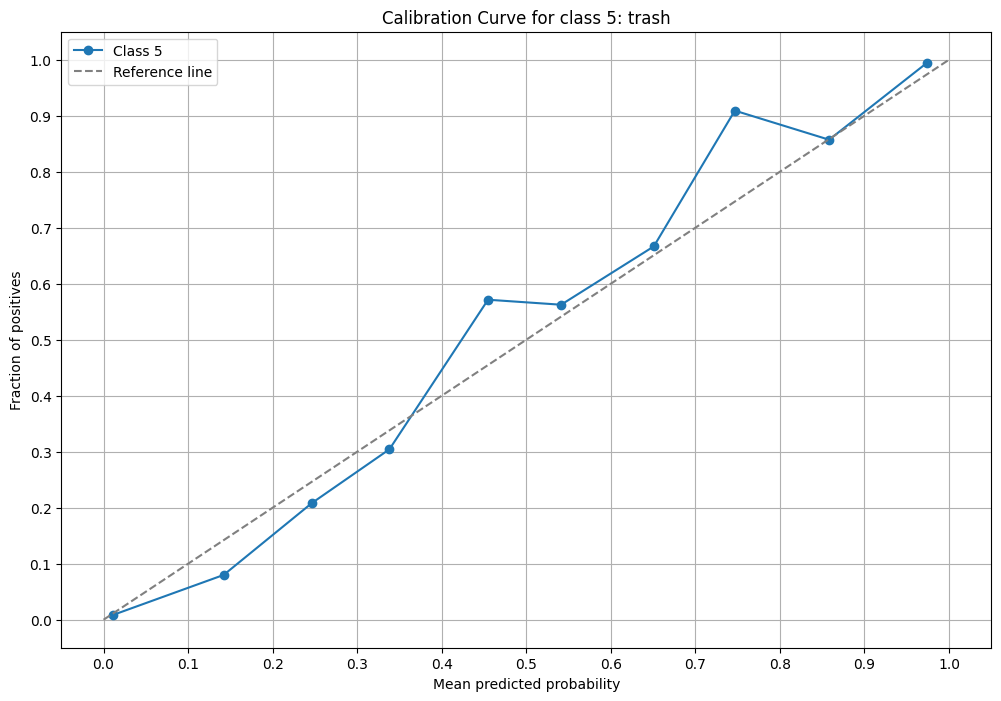

In [9]:
# ================================
# Calibration curves per class
# ================================

for c in range(num_classes):
    plt.figure(figsize=(12, 8))
    
    # y_true: 1 if sample is clase c, else 0
    y_true = (all_labels.numpy() == c).astype(int)
    y_prob = all_probs[:, c]
    
    # calibration_curve returns fraction_of_positives and mean_predicted_value
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    
    plt.plot(mean_pred, frac_pos, marker='o', label=f'Class {c}')

    # Reference line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label = 'Reference line')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curve for class {c}: {cfg.CLASS_NAMES[c]}")
    plt.legend()
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.show()

           0.00-0.10  0.10-0.20  0.20-0.30  0.30-0.40  0.40-0.50  0.50-0.60  \
cardboard   0.032258   0.076923   0.375000        NaN       1.00   0.666667   
glass       0.000000   0.000000   0.083333   1.000000       0.75   0.800000   
metal       0.000000   0.000000   0.375000   0.666667       1.00        NaN   
paper       0.032258   0.133333   0.125000   1.000000       1.00   1.000000   
plastic     0.038462   0.117647   0.272727   0.000000       1.00        NaN   
trash       0.000000   0.125000   0.000000   0.500000        NaN   1.000000   

           0.60-0.70  0.70-0.80  0.80-0.90  0.90-1.00  
cardboard        0.0        NaN        1.0        NaN  
glass            NaN        NaN        1.0        NaN  
metal            1.0        NaN        1.0        NaN  
paper            NaN        1.0        NaN        NaN  
plastic          1.0        NaN        NaN        NaN  
trash            1.0        1.0        1.0        NaN  


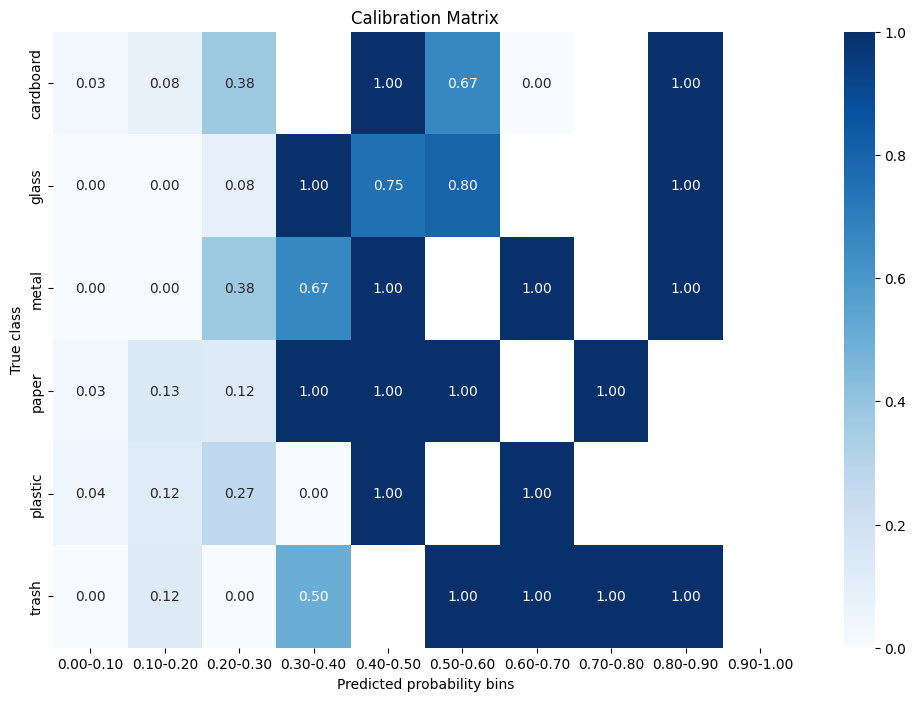

In [125]:
n_bins = 10
bins = np.linspace(0, 1, n_bins+1)
calib_matrix = np.zeros((num_classes, n_bins))

for c in range(num_classes):
    y_true = (all_labels.numpy() == c).astype(int)
    y_prob = all_probs[:, c]
    
    # Digitize probabilities into bins
    bin_indices = np.digitize(y_prob, bins) - 1  
    
    for b in range(n_bins):
        if np.sum(bin_indices == b) > 0:
            frac_pos = y_true[bin_indices == b].mean()
            calib_matrix[c, b] = frac_pos
        else:
            calib_matrix[c, b] = np.nan  # no samples for that bin

# Convert to DataFrame
bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(n_bins)]
calib_df = pd.DataFrame(calib_matrix, index=cfg.CLASS_NAMES, columns=bin_labels)
print(calib_df)

plt.figure(figsize=(12,8))
sns.heatmap(calib_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted probability bins")
plt.ylabel("True class")
plt.title("Calibration Matrix")
plt.show()
